<table>
  <tr>
    <td><p style="font-size:45px; color: #55BBD2">Analysis of light microscopy images in Python</p></td>
    <td><img src="../ressources/lmb_logo.svg" alt="LMB Logo" width="500" height="600" align="right"></td>
  </tr>
</table>
<table>
  <tr>
    <td><p style="font-size:15px; color: #55BBD2">Version: September 2025</p></td>
  </tr>
</table>

# Part 2: Measurement in a region of interest (ROI)

![title](../ressources/data1.png)

In this first analysis problem, our data consists of four channels: ... (Channel 0), actin (Channel 1), ... (Channel 2), and nucleus (Channel 3)

Our region of interest (ROI) is defined by the region delimited by the actins in Channel 1 that have as a "seed" the nuclei in Channel 3. 

We want to measure the number of spots in channel 2 per cell.

The workflow of the analysis is therefore as follows:

<img src="../ressources/workflow/workflow1.png" alt="drawing" width="800"/>

In [2]:
from bioio import BioImage
from pathlib import Path

data_folder = r"Y:\Courses\Given\Python course\data"
image = BioImage(Path(data_folder, 'airyscan-4colors.tif'))

data = image.data

Attempted file (Y:/Courses/Given/Python course/data/airyscan-4colors.tif) load with reader: <class 'bioio_ome_tiff.reader.Reader'> failed with error: bioio-ome-tiff does not support the image: 'Y:/Courses/Given/Python course/data/airyscan-4colors.tif'. Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6


## Image filtering and noise

Filtering is a technique for modifying or enhancing an image. We can filter an image to emphasize certain features or remove other features. Noise filtering is an example of image filtering.

Noise in microscopic image is unavoidable during image acquisition. There are three main categories of noise: 
1. Photon noise, also called shot noise: acquired due to the fluctuation of photon emission to the detector. This is the most dominant noise. It is signal dependent and follows a Poisson distribution. 
2. Dark current or dark noise: accumulated over time due to thermal change as the detector heats up. It is unavoidable but negligible compared to photon noise and is not photon dependent. It follows Poisson distribution. 
3. Readout noise: digital noise acquired during the electronic quantisation of photons. It follows a Gaussian distribution where the standard deviation is constant and the mean is 0.

Dominant noise in fluorescence microscopy follows either a Gaussian distribution or Poisson distribution or both but mostly both. Gaussian noise is additive while Poisson noise is signal dependent. A correct removal of those two different types of noise may therefore differ. Firstly, we will look at how those noise affect the image differently. 

### Noise filtering

There are different types of noise reduction such as smoothing filtering or convolution filtering, median filtering, or frequency filtering. 

As each pixel has a value which represents the image intensity at the spatial position of the pixel, we need to work on each pixel of the image to filter an image.

### Gaussian filter
A smoothing filter uses the principle of convolution to reduce the noise. A convolution process is similar to drawing. The kernel is the pencil that is used for the drawing. So the sharpness of the drawn image really depends on the width of the point of the pencil. In the case of a Gaussian filtering, the Gaussian distribution is used as a kernel. When used for noise filterning, the noise which should have a lower intensity value than the real signal gets smoothed out because of this convolution process.

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Dina Ratsimandresy\AppData\Local\Temp\ipykernel_57204\659295469.py:19: SyntaxWarning: invalid escape sequence '\s'
  axs[1].set_title('Gaussian filtered ($\sigma=$'+str(sigma)+')')
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


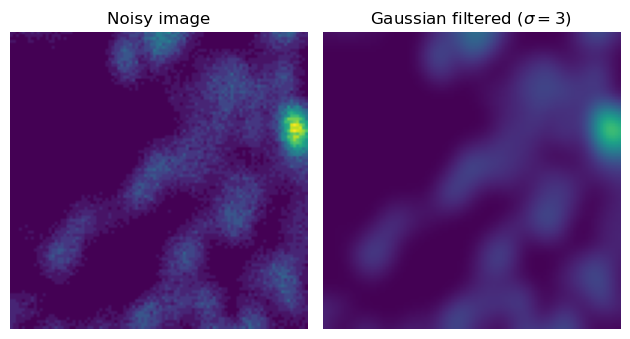

In [3]:
from skimage import filters
import matplotlib.pyplot as plt

# Crop the image and select the first channel
crop = image.data[0, 0, 0, 850:950, 900:1000]

# Gaussian filtering of data with a Gaussian filter of a given sigma
sigma = 3
gaussian_filtered = filters.gaussian(crop.astype(float), sigma)

fig, axs = plt.subplots(1, 2)
vmin, vmax = crop.min(), crop.max()

axs[0].imshow(crop, vmin = vmin, vmax = vmax)                      # original image
axs[0].set_title('Noisy image')
axs[0].set_axis_off()

axs[1].imshow(gaussian_filtered, vmin = vmin, vmax = vmax)                # Gaussian filtered
axs[1].set_title('Gaussian filtered ($\sigma=$'+str(sigma)+')')
axs[1].set_axis_off()

plt.tight_layout()

<div class="alert alert-success">
       
#### Exercise 

In the previous cell, change the standard deviation sigma of the Gaussian kernel and observe the change in the Gaussian filtered image.
    
</div>

### Median filter
A different technique for noise filtering is a median filtering. With the median filter, each output pixel is computed as the median value of the input pixel under a chosen window. 

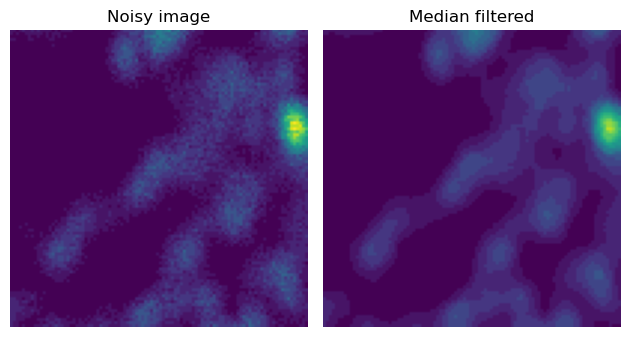

In [4]:
from skimage import filters
import numpy as np

# define the kernel
median_kernel = np.ones((5,5)) 

# the median kernel is introduced in the second argument of the function 
median_filtered = filters.median(crop, median_kernel) 

fig, axs = plt.subplots(1, 2)

# compute the min and max of the original image to keep the same display range
vmin, vmax = crop.min(), crop.max()

axs[0].imshow(crop, vmin = vmin, vmax = vmax)    
axs[0].set_title('Noisy image')
axs[0].set_axis_off()

axs[1].imshow(median_filtered,  vmin = vmin, vmax = vmax)    
axs[1].set_title('Median filtered')
axs[1].set_axis_off()

plt.tight_layout()

<div class="alert alert-success">

#### Exercise       

Change the size of the median kernel and observe the change in the median filtered image.
    
</div>

## Segmentation

Image segmentation is the process of partitioning an image into multiple distinct regions. In semantic segmentation, regions can represent objects of interests against background. They can then be represented as a binary mask. Several type of objects can be further encoded using a label image. Finally, instance segmentation aims at distinguishing different identities of objects of potentially the same class and can also be represented using a label image.

To segment, we need to find the masks which represent each region of interest (ROI). This can easily be done by simply thresholding the intensity of the image. By this, the mask is defined such that only intensity (pixel) values greater than the threshold are selected. If we stop at this stage, we may encounter a problem such that some values within the thresholded region may get discarded because the intensity value is lower than the threshold and the ROI won't be filled. In this case, we may need to find the edge or/and fill the mask region. Another issue that we may encounter is that the edges of the regions may overlap so they may be detected or segmented as one. One solution in this case is to use what is called watershed segmentation. This technique helps to detect the flow of the intensity and decide from there whether the regions form only one object or different objects. 

### Thresholding 

The simplest way of doing this is to use a manually selected threshold, where an intensity value is defined as a threshold.

(np.float64(-0.5), np.float64(1911.5), np.float64(1911.5), np.float64(-0.5))

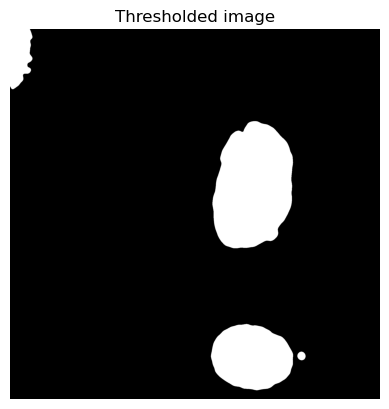

In [5]:
from skimage import filters
import matplotlib.pyplot as plt


nuclei = image.data[0,3,0,:,:] # the object we want to segment and set as markers of our final ROI
nuclei_flt = filters.gaussian(nuclei.astype(float), 10, preserve_range=True) 

threshold = 5 # change threshold value here to see what happens to the mask that is being displayed below
mask = nuclei_flt >= threshold    
plt.imshow(mask, cmap='gray')
plt.title('Thresholded image')
plt.axis('off')

Lets plot the contour of this mask over the image to judge the quality of the segmentation.

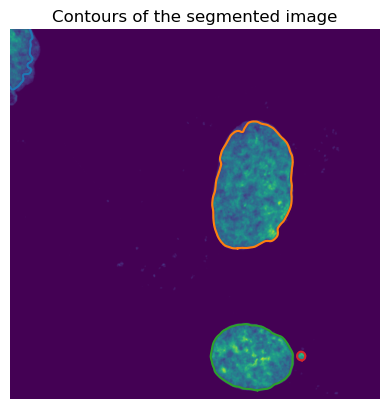

In [6]:
from skimage import measure

contours = measure.find_contours(mask)

plt.imshow(nuclei)
# For each elements of the contours
for contour in contours:
    plt.plot(contour[:,1], contour[:,0])

plt.axis('off')
plt.title('Contours of the segmented image');

### Automated thresholding segmentation 

If a single threshold is not suitable for a collection of images, a thresholding algorithm can be used. One example of this is Otsu's method [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method). More thresholding algorithms can be found in the [skimage.filters package](https://scikit-image.org/docs/stable/api/skimage.filters.html). 

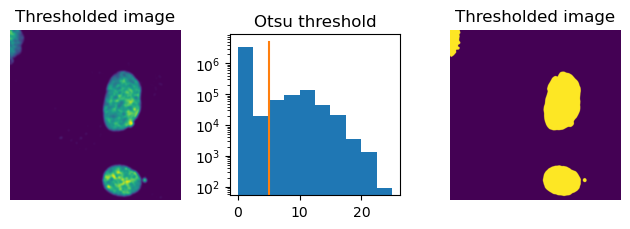

In [7]:
from skimage import filters

# find the threshold value differentiating the signal from background
threshold = filters.threshold_otsu(nuclei_flt) 

# define the threshold mask and close it
nuclei_mask = nuclei_flt > threshold

fig, ax = plt.subplots(1,3)

ax[0].imshow(nuclei_flt)
ax[0].set_title('Thresholded image')
ax[0].set_axis_off()

ax[1].hist(nuclei.ravel(),log=True)
ax[1].plot([threshold, threshold], [0,5e6])
ax[1].set_title('Otsu threshold')
ax[1].set_aspect(5)

ax[2].imshow(nuclei_mask)
ax[2].set_title('Thresholded image')
ax[2].set_axis_off()

plt.tight_layout()

### Post processing of binary masks
The mask obtained after thresholding can be further processed using morphological operations.

C:\Users\Dina Ratsimandresy\AppData\Local\Temp\ipykernel_57204\1339441536.py:8: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  cleared = morphology.closing(only_large_objects, morphology.square(35))


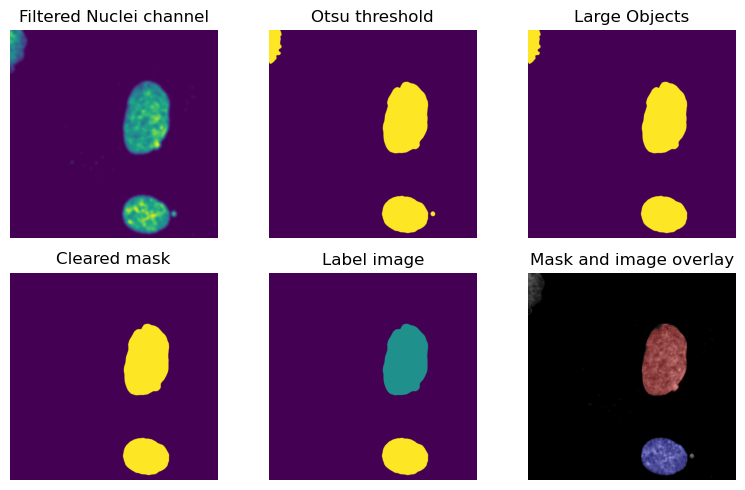

In [8]:
from skimage import morphology
from skimage import segmentation
from skimage import measure
from skimage import color

# remove artifacts connected to image border
only_large_objects = morphology.remove_small_objects(nuclei_mask, 10000)
cleared = morphology.closing(only_large_objects, morphology.square(35))
cleared = segmentation.clear_border(cleared)

# label image regions
nuclei_label = measure.label(cleared)

# label image to rgb 
nuclei_label_overlay = color.label2rgb(nuclei_label, image=10*nuclei, bg_label=0)

fig, ax = plt.subplots(2, 3, figsize=(8,5))

ax[0,0].imshow(nuclei_flt)
ax[0,0].set_title('Filtered Nuclei channel')
ax[0,0].set_axis_off()


ax[0,1].imshow(nuclei_mask)
ax[0,1].set_title('Otsu threshold')
ax[0,1].set_axis_off()

ax[0,2].imshow(only_large_objects)
ax[0,2].set_title('Large Objects')
ax[0,2].set_axis_off()

ax[1,0].imshow(cleared)
ax[1,0].set_title('Cleared mask')
ax[1,0].set_axis_off()

ax[1,1].imshow(nuclei_label)
ax[1,1].set_title('Label image')
ax[1,1].set_axis_off()

ax[1,2].imshow(nuclei_label_overlay)
ax[1,2].set_title('Mask and image overlay')
ax[1,2].set_axis_off()

plt.tight_layout()

### Watershed-based segmentation
The segmentation of the nuclei is pretty straightforward because they are well separated. In some cases however, the objects we want to segment overlap, making it difficult to discern the different regions. In this case, we would need to add extra step into the image segmentation in order to discern the objects. Watershed segmentation is useful for this purpose. It is generally used for separating different objects. Watershed algorithm treats pixels values as a local topography (elevation) so the goal is to follow the flow of the elevation and find the watershed lines from which the edge of each of the regions are deduced. We use this principle to extract our previously defined ROIs: the actin region in Channel-1 having the two nuclei as markers and the seeds of the segmentation. 

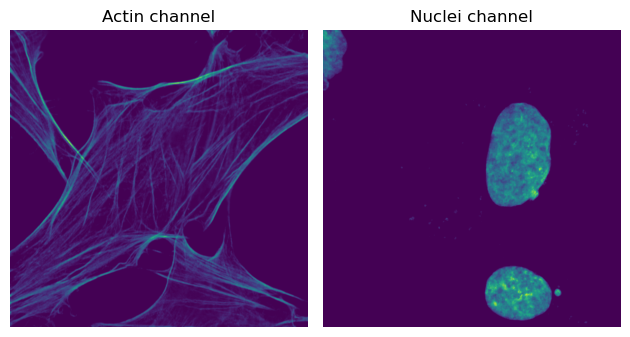

In [9]:
actin  = image.data[0,1,0,:,:] #  the channel we want to segment 

fig, axs = plt.subplots(1,2)
axs[0].imshow(actin)
axs[0].set_title('Actin channel')
axs[0].set_axis_off()

axs[1].imshow(nuclei)
axs[1].set_title('Nuclei channel')
axs[1].set_axis_off()

plt.tight_layout()

#### Mask in the actin channel
Create a mask on the actin using thresholding and morphological operations for closing and filling the mask. In the morphological operations, the erosion and dilation operations are used: <br>
- Erosion: removes small objects so only the big objects will remain in the image,
- Dilation: makes small objects more visible and fills in small holes in objects,
- Closing: a successive operation of those two operations dilation followed by an erosion.

The dynamic range of the intensity values of the actin image is low and it has a 8 bit depth. In this situation, it is very easy to clip out some intensity range or completely change the intensity range. This may yield to a huge error in the analysis. It is always advised to record an image at higher depth or increase the bit depth of the image. Here we convert the 8-bit image into 32-bit floating point.

In [10]:
# convert 8-bit into 32-bit floating point
print('bit depth: ', actin.dtype)
print('(min, max) of the dynamic range of actin =', (np.min(actin), np.max(actin)))

actin_float = actin.astype(np.float32)
print('bit depth: ', actin_float.dtype)

print('(min, max) of the dynamic range of actin_float =', (np.min(actin_float), np.max(actin_float)))

bit depth:  uint8
(min, max) of the dynamic range of actin = (np.uint8(0), np.uint8(49))
bit depth:  float32
(min, max) of the dynamic range of actin_float = (np.float32(0.0), np.float32(49.0))


In the following cell, firstly run the cell. Secondly, replace the input argument actin_float of the filters.gaussian by actin and observe the difference. Thirdly, replace it back to actin_float as the result from actin if of no interest to us.

(min, max) of the dynamic range of smooth_actin = (np.float32(0.0), np.float32(36.50088))


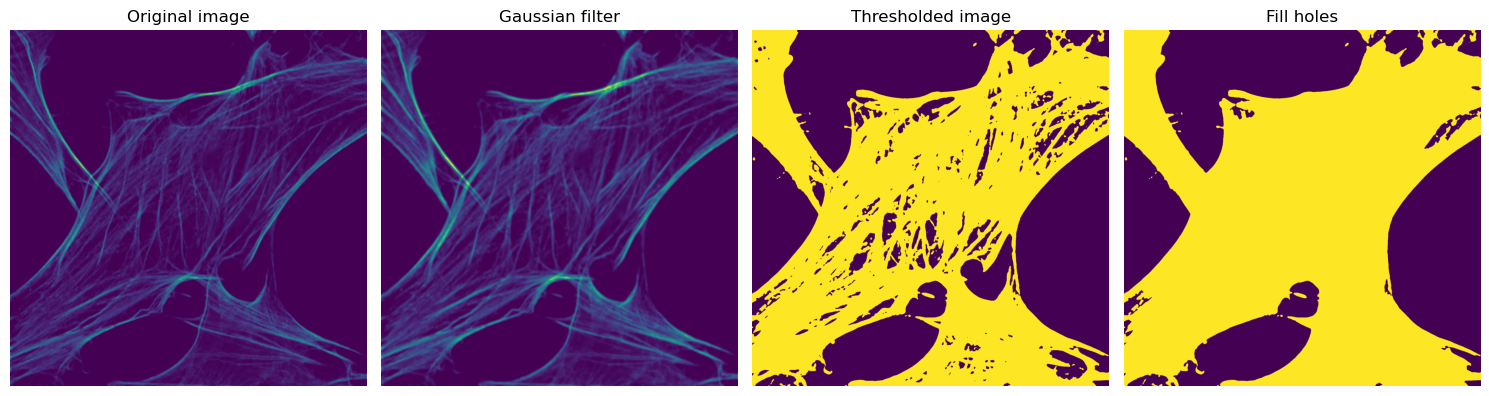

In [11]:
from scipy import ndimage as ndi
from skimage import filters

# smoothed the image using the Gaussian filter with the same sigma as before
smooth_actin = filters.gaussian(actin_float, sigma=3)
print('(min, max) of the dynamic range of smooth_actin =', (np.min(smooth_actin), np.max(smooth_actin)))

# find the optimal threshold
threshold = 0.5

# define the threshold mask
thresh_mask = smooth_actin > threshold

# fill holes to form the the actin_mask without performing the closing function
actin_mask = ndi.binary_fill_holes(thresh_mask).astype(int)

fig, axs = plt.subplots(1,4, figsize=(15, 15))
axs[0].imshow(actin)
axs[0].set_title('Original image')
axs[0].set_axis_off()

axs[1].imshow(smooth_actin)
axs[1].set_title('Gaussian filter')
axs[1].set_axis_off()

axs[2].imshow(thresh_mask)
axs[2].set_title('Thresholded image')
axs[2].set_axis_off()

axs[3].imshow(actin_mask)
axs[3].set_title('Fill holes')
axs[3].set_axis_off()

plt.tight_layout()

#### Distance transform and watershed
The next step will consists of computing the distance transform of the actin mask. Observe how the value of the distance inside the regions change with the spatial coordinates. 

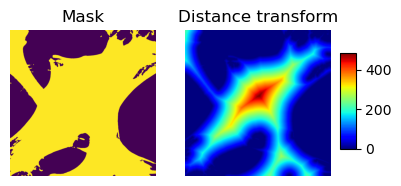

In [12]:
from scipy import ndimage as ndi
distance = ndi.distance_transform_edt(actin_mask) 

fig, ax = plt.subplots(1,3)

ax[0].imshow(actin_mask)
ax[0].set_title('Mask')
ax[0].set_axis_off()

im = ax[1].imshow(distance, cmap='jet')
ax[1].set_title('Distance transform')
ax[1].set_axis_off()

# insert the colorbar 
ax[2].set_position([0.64,0.4,0.025,0.2])
fig.colorbar(im, cax=ax[2])

Now we set the nuclei we segmented before as the markers or seeds of the segmentations. We use the markers to label the segmented regions in the actin region. 
After, we watershed the negative inverse of the distance transform of the actin using the defined markers and within the mask delimited by the actin. The negative inverse of the distance is used in the watershed function instead of the distance because the goal is to have the objects region as valleys not peak.  

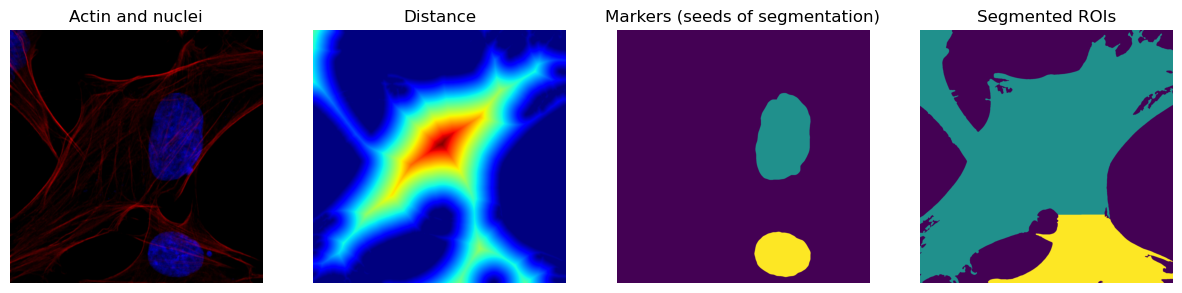

In [13]:
from skimage import segmentation

cell_label = segmentation.watershed(-distance, markers = nuclei_label, mask = actin_mask)

fig, ax = plt.subplots(1,4, figsize=(15, 15))

# create a RGB composite image to display the two channels (normalize channel in between 0 and 1)
rgb = np.stack([actin.astype(float) / actin.max(), 
                np.zeros(actin.shape), 
                nuclei.astype(float) / nuclei.max()], axis=2)

ax[0].imshow(rgb)
ax[0].set_axis_off()
ax[0].set_title('Actin and nuclei')

ax[1].imshow(distance, cmap='jet')
ax[1].set_title('Distance')
ax[1].set_axis_off()

ax[2].imshow(nuclei_label)
ax[2].set_title('Markers (seeds of segmentation)')
ax[2].set_axis_off()

ax[3].imshow(cell_label)
ax[3].set_title('Segmented ROIs')
ax[3].set_axis_off()

<div class="alert alert-success">

#### Exercise       

Copy the cell above and change the code to perform a watershed segmentation using the actin channel as a landscape image. Observe the results.
   
</div>

## Region properties

To measure information within the ROI masks that we have previously segmented, we use the regionprops function. It allows us to define a list of geometrical and intensity properties which can be measured in the images. 

This is a selection of useful properties supported by regionprops:
  - area
  - bbox
  - bbox_area
  - centroid
  - coords
  - equivalent_diameter
  - label
  - major_axis_length
  - max_intensity
  - mean_intensity
  - min_intensity
  - minor_axis_length
  - slice
  - solidity
  - eccentricity
  - orientation
  - perimeter

### Maximum Intensity

In [14]:
import pandas as pd
from skimage import measure


signal = image.data[0,0,:,:].squeeze()
signal_table = measure.regionprops_table(cell_label, signal, properties=('label', 'intensity_max'))
results = pd.DataFrame(signal_table)

results

,label,intensity_max
0,1,19.0
1,2,12.0


In [15]:
import pandas as pd
from skimage import measure

signal = image.data[0,0,:,:].squeeze()

signal_props = measure.regionprops(cell_label, signal)
actin_props = measure.regionprops(cell_label, actin)

# Get the list of labels from the regions properties
labels = [p.label for p in signal_props]

# Get the maximum intensity for the properties
signal_max_intensity = [p.intensity_max for p in signal_props]
actin_max_intensity = [p.intensity_max for p in actin_props]

# Gather the results in a data frame (table)
results = pd.DataFrame({
    'Region label': labels, 
    'Signal [ch0] maximum intensity': signal_max_intensity,
    'Actin [ch1] maximum intensity': actin_max_intensity})

results

,Region label,Signal [ch0] maximum intensity,Actin [ch1] maximum intensity
0,1,19.0,49.0
1,2,12.0,33.0


<div class="alert alert-success">

#### Exercise 

Use one of the methods above to measure the perimeter of the nuclei. Store the results in a variable called "perimeter_nuclei".
</div>

### Defining a custom measurement

The information about the median is currently not included in the regionprops function. Here we show how can we extract the intensity median for each ROI using a custom function. The median of a list is defined as the middle element of the list when the list is sorted. 

In [16]:
# Define a custom function to measure median intensity
def median_intensity(mask, intensity):
    '''Median intenisty in a mask

    Parameters
    ----------
    mask : binary image
    intensity: intensity  image

    Returns
    -------
    The median intensity in the mask
    '''
    return np.median(intensity[mask])

actin_props = measure.regionprops_table(cell_label, actin, 
                                 properties = ('label','mean_intensity'), 
                                 extra_properties = (median_intensity,))

results = pd.DataFrame(actin_props)

results

,label,mean_intensity,median_intensity
0,1,4.276166,3.0
1,2,4.172375,3.0


## Save result
Export the result stored in the panda dataframe into a csv file

In [ ]:
results.to_csv('mean_median_results.csv')

<div class="alert alert-success">

#### Extra exercise 

At the end of this course, you can use the techniques described in this Python notebook and find the number of particles in Channel 2 of the data airyscan-4colors.tif within the labelled regions that we segmented above. 

Hint: <br>
1- use the blob detection used in the third analysis problem to find the position of the particles <br>
2- generate the locations of all the blobs <br>
3- measure the regionprops of the cell mask <br>
4- count how many blobs coordinates are there per segmented cell
</div>